In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7325814.datarmor0/parcels-502090/libparcels_random_6f355cda-42f8-4859-8bc4-d6b893147706.so


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=2
#                 )
#
client = Client(cluster)

In [3]:
isel = dict(face=7)
#sel = dict(i=slice(2700,2900), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
sel = dict(i=[2900,2910], j=[2900,2910])#, i_g=[2900,2910], j_g=[2900,2910]) # North East Hawaii

In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [5]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr'),xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr'),
               xr.open_zarr(ut.work_data_dir+'rechunked/Eta.zarr')
              ])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [6]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})#.drop(['i_g','j_g'])
ds = ds.isel(time=slice(0*24,50*24))

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [7]:
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10
dsp

<xarray.Dataset>
Dimensions:  (i: 2, j: 2, time: 1200)
Coordinates:
  * i        (i) int64 2900 2910
  * j        (j) int64 2900 2910
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-01-03T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(1200, 2, 2), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(1200, 2, 2), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1200, 2, 2), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>

In [8]:
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()


In [9]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1","S2")
omega_M2,omega_S2, domega, name = tidal_omega["M2"],tidal_omega["S2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2
h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

print(omega_M2,omega_S2)

1.9322736142672448 2.0


No handles with labels found to put in legend.


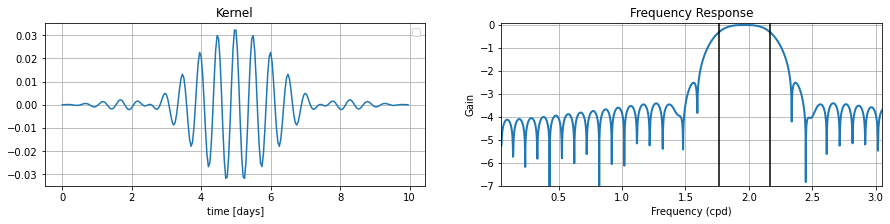

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [11]:
for v in ['zonal_velocity','meridional_velocity','Eta']:
    dsp[v+"_hat"] = filt(dsp[v], h,hilbert=True
                        )
dsp = dsp.persist()

In [67]:
time = np.arange(0,ds['time'].values.size*dt,dt)
exp = np.exp(-1j*omega*2*np.pi*time)
for v in ['zonal_velocity','meridional_velocity','Eta']:
    dsp[v+'_hat'] = dsp[v+'_hat'].assign_coords({'lon':dsp[v+'_hat'].lon,'lat':dsp[v+'_hat'].lat})
    dsp[v+'_demodulated'] = dsp[v+'_hat']*exp

dsp = xr.merge([dsp[v].rename(v) for v in dsp.keys()])

In [124]:
#omega = ds.ssh_cd.attrs["omega"] # frequency of complex demodulation
deloms = [2*np.pi*(omega_M2 - omega), 2*np.pi*(omega_S2 - omega)]#, 
#          2*np.pi/12.66-omega, 2*np.pi/11.96-omega] # delta omega for all constituents
fcomp = ["M", "S"]#, "N", "K"] # name of constituents (for plotting)

def harmo(amp, dom, t):
    """ single harmonic wave """
    return amp * np.exp(1.j*dom*t)

def fitfunc(p, t):
    """ sum of harmonic waves """
    res = harmo(p[0], deloms[0], t)
    for i in range(1,len(p)):
        res += harmo(p[i], deloms[i], t)
    return res

def errfunc(p, t, y):
    """ error function """
    return y - fitfunc(p, t)

def wrap_err(p, t, y):
    """ concatenate real part and imaginary part of the error function """
    p = np.array([p[2*i] + 1.j*p[2*i+1] for i in range(len(p)//2)])
    res = errfunc(p, t, y)
    return np.r_[res.real, res.imag]

def wrap_fit(yy, tt, deloms=deloms):
    """ wrap least square fit of a sum of harmonics (with len(deloms) frequencies) 
    for a complex time series. Fitted parameters are the complex amplitude of the harmonics.
    returns the parameters of the fit, the rms of the time series and the rms of the residual
    see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
    """
    No = len(deloms)
    if not np.isnan(yy).all():
        p0 = np.c_[np.ones(No), np.zeros(No)].ravel()
        try:
            res = opt.least_squares(wrap_err, p0, args=(tt,yy))
            pout = np.array([res.x[2*i] + 1.j*res.x[2*i+1] for i in range(No)]).astype("complex64")
            rms_tot = (yy*yy.conj()).real.mean()**.5
            yr = yy - fitfunc(pout, tt)
            rms_res = (yr*yr.conj()).real.mean()**.5
        except:
            pout = np.zeros(No)+0.j+np.nan
            rms_tot, rms_res = 0.j+np.nan, 0.j+np.nan
        return np.r_[pout, rms_tot, rms_res]
    else:
        return np.ones(No+2)*np.nan

def wrap_harmo_res(da, deloms=deloms):
    """ wrap "wrap_fit" in xarray.apply_ufunc for running and parallelizing with dask """
    n_out = 2+len(deloms)
    #da = da.chunk({"t":-1})
    res = xr.apply_ufunc(wrap_fit, da, da.time, 
                        input_core_dims=[["time"], ["time"]], output_core_dims=[["stack"]], vectorize=True,
                        dask="parallelized", output_dtypes="complex64", output_sizes={"stack":n_out})
    ds = res.isel(stack=slice(0,n_out-2)).rename({"stack":"fcomp"}).to_dataset(name="cha")
    ds = ds.assign_coords(fcomp=deloms)
    ds["rms_tot"] = res.isel(stack=-2).real
    ds["rms_res"] = res.isel(stack=-1).real
    return ds

In [106]:
_ds = dsp.isel(i=0,j=0,time=slice(0,20*24)).compute()

In [107]:
time = np.arange(0,_ds['time'].values.size*dt,dt)
exp = np.exp(-1j*omega*2*np.pi*time)

In [108]:
for v in ['zonal_velocity','meridional_velocity','Eta']:
    _ds[v+'_hat'] = _ds[v+'_hat'].assign_coords({'lon':_ds[v+'_hat'].lon,'lat':_ds[v+'_hat'].lat})
    _ds[v+'_demodulated'] = _ds[v+'_hat']*exp
_ds = xr.merge([_ds[v].rename(v) for v in _ds.keys()])

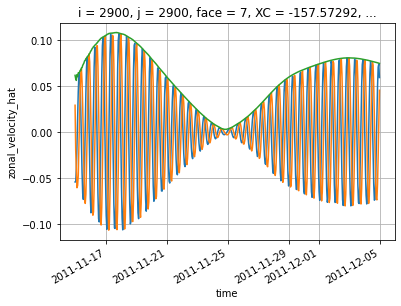

In [109]:
np.real(_ds['zonal_velocity_hat']).plot();
np.imag(_ds['zonal_velocity_hat']).plot();
np.abs(_ds['zonal_velocity_hat']).plot();
plt.grid();

In [111]:
tt = np.arange(0,_ds.time.values.size*dt,dt)
yy_demod = _ds.zonal_velocity_demodulated.values
yy_hat = _ds.zonal_velocity_hat.values

In [112]:
import scipy.optimize as opt

In [113]:
test_demod = wrap_fit(yy_demod,tt)
test_hat = wrap_fit(yy_hat,tt)

In [114]:
M2_demod = test_demod[0]*np.exp(1j*deloms[0]*tt)#test[0]*np.exp(1j*omega_M2*time)#
S2_demod = test_demod[1]*np.exp(1j*deloms[1]*tt)#test[0]*np.exp(1j*omega_M2*time)#
M2_hat = test_hat[0]*np.exp(1j*omega_M2*tt)#test[0]*np.exp(1j*omega_M2*time)#
S2_hat = test_hat[1]*np.exp(1j*omega_S2*tt)#test[0]*np.exp(1j*omega_M2*time)#

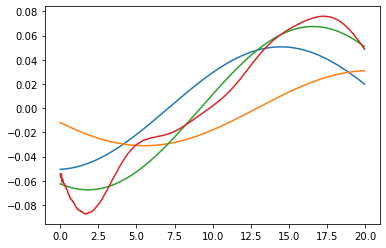

In [116]:
plt.plot(tt,np.real(M2_demod))
plt.plot(tt,np.real(S2_demod))
plt.plot(tt,np.real(S2_demod+M2_demod))
plt.plot(tt,np.real(_ds['zonal_velocity_demodulated']).values)

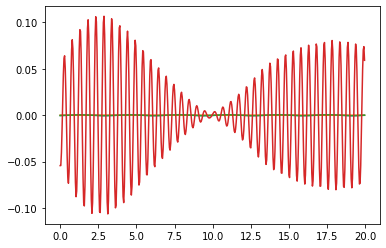

In [117]:
plt.plot(tt,np.real(M2_hat))
plt.plot(tt,np.real(S2_hat))
plt.plot(tt,np.real(S2_hat+M2_hat))
plt.plot(time,np.real(_ds['zonal_velocity_hat']).values)

In [118]:
ds_inc = _ds['zonal_velocity_demodulated']-(M2_demod+S2_demod)

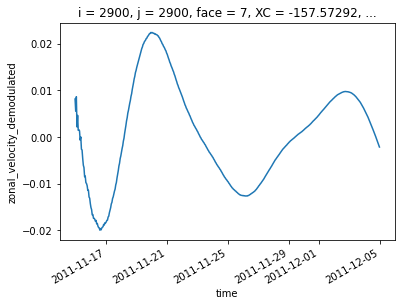

In [119]:
np.real(ds_inc).plot()

In [126]:
y = wrap_harmo_res(dsp['zonal_velocity_demodulated']).persist()

<ipython-input-124-3031789ecfcc>:53: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  res = xr.apply_ufunc(wrap_fit, da, da.time,


In [137]:
#_ds_ana = 
y.cha*np.exp(np.multiply(1j,deloms).reshape(2,1)*time.reshape(1,480))

ValueError: operands could not be broadcast together with shapes (2, 2, 2) (2, 480)

In [88]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        #if _ds1.dtype=='complex128':
        #    _kwargs = {'mode': 'full','detrend':detrend}
        #else:
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
        
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [69]:
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        #lags = np.arange(0,T//2+dt,dt)[:T//2*1/dt+1]
        if v1.dtype=='complex128':
            dtype=np.complex128
        else:
            dtype=np.float64
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[dtype], #np.float64
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [70]:
T = 10 #time window size (size of th segments)
dt = 1/24#float((ds.time[1]-ds.time[0]).values) # time step


In [94]:
# Autocorrelation of v`
lags = np.arange(0,T//2+dt,dt)[:int(T//2*1/dt)+1]
_u = _ds['zonal_velocity_demodulated']#.sel(T_window=20,bandwidth=0.2)

C = wrap_correlate(np.real(_u), np.real(_u),dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt)).persist()

<ipython-input-69-ac02ba5bbbb9>:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,


In [72]:
_u

<xarray.DataArray 'zonal_velocity_hat' (j: 2, i: 2, time: 1200)>
dask.array<transpose, shape=(2, 2, 1200), dtype=complex128, chunksize=(2, 2, 1200), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 2900 2910
  * j        (j) int64 2900 2910
    face     int64 7
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-01-03T23:00:00
    XC       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>

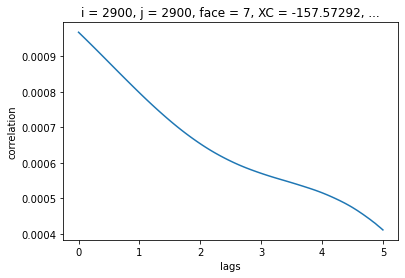

In [96]:
C.plot()

In [79]:
Ni = _u.shape[:-1]
    # infer number of lags from dummy computation
i0 = tuple(0 for i in Ni) + np.s_[:,]
 #   f = _correlate(v1[i0], v2[i0], **_kwargs)
 #   vv = np.full(Ni+f.shape, np.NaN)
#correlate_E(np.real(_u.values),np.real(_u.values),roll=True,dt=dt, Nr=int(T/dt))

In [87]:
np.real(_u)[i0].size
int(T/dt)
roll_correlate(np.real(_u)[i0],np.real(_u)[i0],Nr=int(T/dt))

[array([ 8.83772492e-04,  7.83670276e-04,  4.71908938e-04,  2.54786546e-05,
        -4.40569393e-04, -8.02786177e-04, -9.62013051e-04, -8.70438521e-04,
        -5.45658551e-04, -6.76683030e-05,  4.40828049e-04,  8.45944564e-04,
         1.03786688e-03,  9.60544743e-04,  6.27809541e-04,  1.21335713e-04,
        -4.29411244e-04, -8.80314533e-04, -1.11033596e-03, -1.05395002e-03,
        -7.19601083e-04, -1.89029525e-04,  4.02730895e-04,  9.01782831e-04,
         1.17542476e-03,  1.14740009e-03,  8.18978458e-04,  2.70077579e-04,
        -3.60216652e-04, -9.08973422e-04, -1.23158976e-03, -1.23988015e-03,
        -9.26050613e-04, -3.66067915e-04,  2.98771747e-04,  8.97589884e-04,
         1.27391865e-03,  1.32659275e-03,  1.03684921e-03,  4.74396206e-04,
        -2.19406215e-04, -8.67181158e-04, -1.30097374e-03, -1.40582941e-03,
        -1.15019550e-03, -5.95119199e-04,  1.20379192e-04,  8.14238964e-04,
         1.30778967e-03,  1.47181159e-03,  1.26033792e-03,  7.23363068e-04,
        -5.0

In [138]:
cluster.close()